In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pprint

# tweaks for above libraries
# Numpy/Pandas & Matplotlib tweaks
# tweaks for Numpy & Pandas (see respective documentation)
pd.set_option('display.notebook_repr_html',True)
pd.set_option('display.max_rows',15)
pd.set_option('display.max_columns',25)
pd.set_option('display.width',1024)
# force all Numpy & Pandas floating point output to 3 decimal places
float_formatter = lambda x: '%.4f' % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.set_option('display.float_format', float_formatter)
# force Numpy to display very small floats using floating point notation
np.set_printoptions(threshold=np.inf, suppress=True, precision=4, linewidth=2048)
# force GLOBAL floating point output to 4 decimal places
%precision 4

# tweaks for Seaborn plotting library
sns.set_style('darkgrid')
plt.style.use('seaborn-muted')
sns.set_style({'font.sans-serif':['Verdana','Arial','Calibri','DejaVu Sans']})
sns.set_context('talk')

seed = 42
np.random.seed(seed)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data/"))

# Any results you write to the current directory are saved as output.

Pretty printing has been turned OFF
['submission_randomforest.csv', 'test.csv', 'submission.csv', 'train.csv', '.ipynb_checkpoints']


/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_59688/492678909.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


In [4]:
path='/Users/Shark/Encore/ML/titanic_challenge'
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')

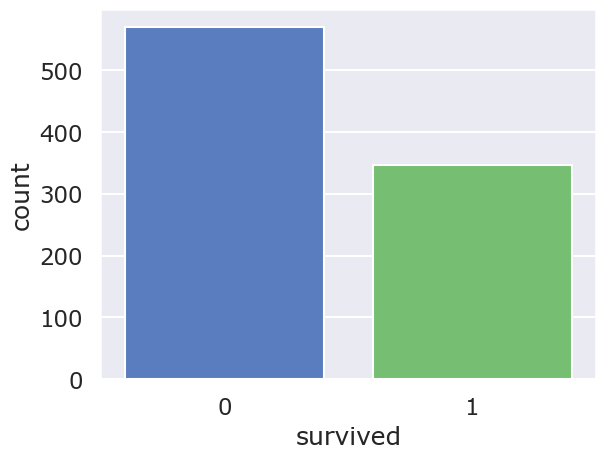

In [5]:
_ = sns.countplot(x='survived',data=train_df)
plt.show()
plt.close()  # to release plotting resources and reduce memory consumption!

In [6]:
familyOnBoard = lambda row : 1 if ((row.sibsp > 0) or (row.parch > 0)) else 0 

train_df['fob'] = train_df.apply(familyOnBoard, axis=1)
test_df['fob'] = test_df.apply(familyOnBoard, axis=1)

train_df[['survived','sibsp','parch','fob']].head()
#train_df[['Survived','SibSp','Parch','Fob']].head()

,survived,sibsp,parch,fob
0,0,0,0,0
1,0,0,0,0
2,1,1,1,1
3,1,0,0,0
4,0,1,0,1


In [7]:
train_df['title'] = train_df.name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['title'] = test_df.name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [9]:
train_df[['name','title','gender','age']].head(10)

,name,title,gender,age
0,"Wheeler, Mr. Edwin Frederick""""",Mr,male,NaN
1,"Henry, Miss. Delia",Miss,female,NaN
2,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",Mrs,female,52.0000
3,"Andersson, Mr. August Edvard (""Wennerstrom"")",Mr,male,27.0000
4,"Hold, Mr. Stephen",Mr,male,44.0000
5,"Rosblom, Mrs. Viktor (Helena Wilhelmina)",Mrs,female,41.0000
6,"Novel, Mr. Mansouer",Mr,male,28.5000
7,"Kelly, Miss. Anna Katherine ""Annie Kate""",Miss,female,NaN
8,"de Brito, Mr. Jose Joaquim",Mr,male,32.0000
9,"Petersen, Mr. Marius",Mr,male,24.0000


In [11]:
np.unique(train_df['title'])

array(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Major', 'Master', 'Miss', 'Mlle', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir'], dtype=object)

In [13]:
male_titles = ['Capt', 'Col', 'Don','Jonkheer','Major','Rev','Sir'] # all classified as male
female_titles = ['Countess','Dona','Lady'] # all as female
miss_titles = ['Mlle','Ms','Mme']

for df in [train_df, test_df]:
    df['title'] = df['title'].replace(miss_titles, 'Miss')
    df['title'] = df['title'].replace(female_titles, 'Mrs')
    df['title'] = df['title'].replace(male_titles, 'Mr')
    male_dr_filter = (df.title == 'Dr') & (df.gender == 'male')
    female_dr_filter = (df.title == 'Dr') & (df.gender == 'female')
    df.loc[male_dr_filter, ['title']] = 'Mr'
    df.loc[female_dr_filter, ['title']] = 'Mrs'

In [14]:
combo_df = pd.concat((train_df,test_df))
pd.crosstab(combo_df['title'], combo_df['gender'])

gender,female,male
title,,
Master,0,61
Miss,265,0
Mr,0,782
Mrs,201,0


In [15]:
del combo_df

In [16]:
for df in [train_df, test_df]:
    df.drop(['name','ticket','cabin'],axis=1,inplace=True)

In [17]:
train_df.head()

,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,fob,title
0,0,0,2,male,NaN,0,0,12.8750,S,0,Mr
1,1,0,3,female,NaN,0,0,7.7500,Q,0,Miss
2,2,1,1,female,52.0000,1,1,93.5000,S,1,Mrs
3,3,1,3,male,27.0000,0,0,7.7958,S,0,Mr
4,4,0,2,male,44.0000,1,0,26.0000,S,1,Mr


In [18]:
test_df.head()

,passengerid,pclass,gender,age,sibsp,parch,fare,embarked,fob,title
0,916,3,female,15.0000,0,0,8.0292,Q,0,Miss
1,917,2,female,32.0000,0,0,13.0000,S,0,Mrs
2,918,3,female,NaN,0,0,7.7500,Q,0,Miss
3,919,3,male,NaN,0,0,7.2500,S,0,Mr
4,920,1,female,45.0000,1,1,164.8667,S,1,Mrs


In [19]:
combo_df = pd.concat((train_df,test_df))
combo_df.isnull().sum()

passengerid      0
survived       393
pclass           0
gender           0
age            263
sibsp            0
parch            0
fare             1
embarked         2
fob              0
title            0
dtype: int64

In [20]:
del combo_df

In [21]:
# Embarked - replace missing values (2 rows) with most common value (i.e. mode()) of Embarked field
for df in [train_df, test_df]:
    df['embarked'].fillna(df['embarked'].mode()[0],inplace=True)

In [23]:
values = {'fare': 0.0} 
for df in [train_df, test_df]:
    df.fillna(value=values,inplace=True)

In [25]:
# create fare lookup tables for train_df & test_df
fare_table_train = (train_df.loc[train_df.fare != 0.0][['pclass','fare']].groupby(['pclass']).median()).copy()
fare_table_train

,fare
pclass,
1,60.0000
2,15.0458
3,8.0500


In [26]:
train_df.fare.isnull().sum()

0

In [27]:
# Age - replace age with mean age by title (which we had 'computed' earlier)

# find mean age by Title, for rows where age is not Null
age_lookup_train = (train_df.loc[(train_df['age'] != 0.0), ['age', 'title']].groupby('title').mean()).copy()
age_lookup_train

,age
title,
Master,5.3523
Miss,21.7887
Mr,32.5082
Mrs,36.8992


In [28]:
age_lookup_test = (test_df.loc[(test_df['age'] != 0.0), ['age', 'title']].groupby('title').mean()).copy()
age_lookup_test

,age
title,
Master,5.7361
Miss,21.9495
Mr,33.4574
Mrs,37.5818


In [29]:
train_df.loc[train_df.age.isnull()][:10]

,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,fob,title
0,0,0,2,male,NaN,0,0,12.8750,S,0,Mr
1,1,0,3,female,NaN,0,0,7.7500,Q,0,Miss
7,7,1,3,female,NaN,0,0,7.7500,Q,0,Miss
13,13,0,3,female,NaN,8,2,69.5500,S,1,Miss
15,15,0,3,male,NaN,0,0,7.0500,S,0,Mr
20,20,0,2,male,NaN,0,0,0.0000,S,0,Mr
24,24,1,3,female,NaN,0,0,7.7500,Q,0,Miss
26,26,0,3,male,NaN,0,0,7.2250,C,0,Mr
33,33,0,2,male,NaN,0,0,0.0000,S,0,Mr
39,39,0,3,male,NaN,0,0,7.2292,C,0,Mr


In [30]:
test_df.loc[test_df.age.isnull()][:10]

,passengerid,pclass,gender,age,sibsp,parch,fare,embarked,fob,title
2,918,3,female,NaN,0,0,7.7500,Q,0,Miss
3,919,3,male,NaN,0,0,7.2500,S,0,Mr
7,923,3,male,NaN,0,0,7.7500,Q,0,Mr
10,926,3,male,NaN,1,0,15.5000,Q,1,Mr
13,929,3,female,NaN,1,0,14.4583,C,1,Mrs
17,933,2,male,NaN,0,0,10.7083,Q,0,Mr
18,934,3,male,NaN,0,0,6.4375,C,0,Mr
19,935,3,male,NaN,0,0,7.7500,Q,0,Mr
22,938,3,male,NaN,0,0,7.7333,Q,0,Mr
24,940,3,male,NaN,1,0,7.7500,Q,1,Mr


In [31]:
for title in ['Master','Miss','Mr','Mrs']:
    print('%7s -> %8.3f %8.3f' % (title,age_lookup_train.loc[title], age_lookup_test.loc[title]))

 Master ->    5.352    5.736
   Miss ->   21.789   21.950
     Mr ->   32.508   33.457
    Mrs ->   36.899   37.582


In [32]:
# replace the Nulls from the Age lookups
for df, age_lookup in zip([train_df, test_df],[age_lookup_train, age_lookup_test]):
    for title in ['Master','Miss','Mr','Mrs']:
        df.loc[((df['title'] == title) & (df['age'].isnull())),['age']] = age_lookup.loc[title][0]

In [34]:
train_df.loc[[2,3,7],['title','age']]

,title,age
2,Mrs,52.0000
3,Mr,27.0000
7,Miss,21.7887


In [35]:
# we will pick the following fields for running our models
fields_train = ['survived', 'pclass', 'title', 'age', 'fare', 'embarked','fob']
fields_test = ['pclass', 'title', 'age', 'fare', 'embarked','fob']
# NOTE: 
# - dropping features Sex, SibSp, Parch from datasets
# - Sex not picked - Title picked instead, which includes 'Sex' implicitly
# - Sibsp and Parch not picked - Fob picked instead, which == 1 if SibSp > 0 or Parch > 0
train_df2 = train_df[fields_train]
test_df2 = test_df[fields_test]

In [36]:
train_df2.head()

,survived,pclass,title,age,fare,embarked,fob
0,0,2,Mr,32.5082,12.8750,S,0
1,0,3,Miss,21.7887,7.7500,Q,0
2,1,1,Mrs,52.0000,93.5000,S,1
3,1,3,Mr,27.0000,7.7958,S,0
4,0,2,Mr,44.0000,26.0000,S,1


In [37]:
test_df2.head()

,pclass,title,age,fare,embarked,fob
0,3,Miss,15.0000,8.0292,Q,0
1,2,Mrs,32.0000,13.0000,S,0
2,3,Miss,21.9495,7.7500,Q,0
3,3,Mr,33.4574,7.2500,S,0
4,1,Mrs,45.0000,164.8667,S,1


/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_59688/3700927068.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_df2.corr()


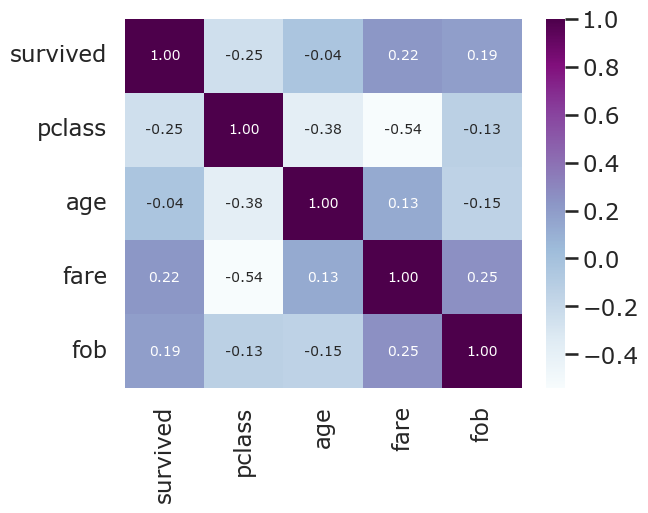

In [39]:
corr = train_df2.corr()
sns.heatmap(corr, cmap='BuPu', fmt='.2f',cbar=True, annot=True,annot_kws={"size": 10})
plt.show()

In [40]:
for df in [train_df2, test_df2]:
    df['title'] = df['title'].map( {'Miss': 4, 'Mrs': 3, 'Master': 2, 'Mr': 1} ).astype(int)
    df['embarked'] = df['embarked'].map( {'S': 3, 'C': 2, 'Q': 1} ).astype(int)

/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_59688/2847921460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].map( {'Miss': 4, 'Mrs': 3, 'Master': 2, 'Mr': 1} ).astype(int)
/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_59688/2847921460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embarked'] = df['embarked'].map( {'S': 3, 'C': 2, 'Q': 1} ).astype(int)
/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_59688/2847921460.py:2: SettingWi

In [41]:
train_df2.head()

,survived,pclass,title,age,fare,embarked,fob
0,0,2,1,32.5082,12.8750,3,0
1,0,3,4,21.7887,7.7500,1,0
2,1,1,3,52.0000,93.5000,3,1
3,1,3,1,27.0000,7.7958,3,0
4,0,2,1,44.0000,26.0000,3,1


In [42]:
test_df2.head()

,pclass,title,age,fare,embarked,fob
0,3,4,15.0000,8.0292,1,0
1,2,3,32.0000,13.0000,3,0
2,3,4,21.9495,7.7500,1,0
3,3,1,33.4574,7.2500,3,0
4,1,3,45.0000,164.8667,3,1


In [43]:
# Title & Embarked needs to be One-hot-encoded as well. We'll use pandas.get_dummies()
train_df2 = pd.get_dummies(train_df2,columns=['title','embarked'],drop_first=True)
test_df2 = pd.get_dummies(test_df2,columns=['title','embarked'],drop_first=True)

In [44]:
train_df2.head()

,survived,pclass,age,fare,fob,title_2,title_3,title_4,embarked_2,embarked_3
0,0,2,32.5082,12.8750,0,0,0,0,0,1
1,0,3,21.7887,7.7500,0,0,0,1,0,0
2,1,1,52.0000,93.5000,1,0,1,0,0,1
3,1,3,27.0000,7.7958,0,0,0,0,0,1
4,0,2,44.0000,26.0000,1,0,0,0,0,1


In [48]:
target_col = train_df2.columns.values[0]
columns = train_df2.columns.values[1:]
target_col, columns

('survived', array(['pclass', 'age', 'fare', 'fob', 'title_2', 'title_3', 'title_4', 'embarked_2', 'embarked_3'], dtype=object))

In [122]:
train = pd.read_csv('data/eda_ext_train.csv')
test = pd.read_csv('data/eda_ext_test.csv')

In [ ]:
X_train

In [49]:
# NOTE: we are going to be using k-fold cross validation, so it is not required to split the data into train/test sets
X_train, X_test = train_df2[columns], test_df2[columns]
y_train = train_df2[target_col]   # NOTE' there is no y_test!
X_train.shape, y_train.shape, X_test.shape

((916, 9), (916,), (393, 9))

,pclass,age,fare,fob,title_2,title_3,title_4,embarked_2,embarked_3
0,2,32.5082,12.8750,0,0,0,0,0,1
1,3,21.7887,7.7500,0,0,0,1,0,0
2,1,52.0000,93.5000,1,0,1,0,0,1
3,3,27.0000,7.7958,0,0,0,0,0,1
4,2,44.0000,26.0000,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
911,3,32.5082,6.4375,1,0,0,0,1,0
912,3,18.0000,8.6625,0,0,0,0,0,1
913,2,19.0000,10.5000,0,0,0,0,0,1
914,3,21.7887,7.7333,0,0,0,1,0,0


In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [105]:
# Helper functions
def do_kfold_cv(classifier, X_train, y_train, n_splits=4, scoring='roc_auc'):
    """ do a k-fold cross validation run on classifier & training data
      and return cross-val scores """   
    kfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cv_scores = cross_val_score(classifier, X_train, y_train,scoring=scoring,cv=kfolds)
    return cv_scores

def test_classifier(clf_tuple, X_train, y_train, scoring='roc_auc', plot_feat_imp=False, verbose=2):
    """ run a k-fold test, fit model to training data & report scores for training & test data """
    # extract classifier instance & name
    clf, clf_name = clf_tuple
   
    if verbose > 0:
        print('Testing classifier %s...' % clf_name)
    
    clf.fit(X_train, y_train)
    
    acc_score = clf.score(X_train, y_train)

    # k-fold cross validation
    cv_scores = do_kfold_cv(clf, X_train, y_train)
    mean_cv_scores, std_cv_scores, min_cv_scores, max_cv_scores = \
        np.mean(cv_scores), np.std(cv_scores), np.min(cv_scores), np.max(cv_scores)
        
    # roc-auc score
    y_pred_proba = clf.predict_proba(X_train)[:,1]
    auc_score = roc_auc_score(y_train, y_pred_proba)

    if verbose > 1:   
        print('   - cross-val scores : Mean - %.3f Std - %.3f Min - %.3f Max - %.3f' % 
                  (mean_cv_scores, std_cv_scores, min_cv_scores, max_cv_scores))
        print('   - accuracy score   : %.3f' % acc_score)
        print('   - auc score        : %.3f' % auc_score)
        
    if plot_feat_imp:
        feat_imp = pd.DataFrame(clf.feature_importances_, index=columns, columns=['feature_imp'])
        feat_imp.sort_values(by='feature_imp', ascending=False, inplace=True)
        #print(feat_imp)
        feat_imp.plot(kind='bar', title='Feature Importances', legend=False)
        plt.ylabel('Feature Importance Score')
        plt.show()
        plt.close()

    return cv_scores, acc_score, auc_score

def test_classifiers(clf_list, X_train, y_train, scoring='roc_auc', verbose=2):
    """ run a list of classifiers against the training & test sets and
        return a pandas DataFrame of scores """
    classifier_names = []
    clf_cv_scores = []
    clf_acc_scores = []
    clf_auc_scores = []
    
    for clf_tuple in clf_list:
        cv_scores, acc_score, auc_score = \
            test_classifier(clf_tuple, X_train, y_train, scoring=scoring, verbose=verbose)
        classifier, classifier_name = clf_tuple
        classifier_names.append(classifier_name)
        clf_cv_scores.append(np.mean(cv_scores))
        clf_acc_scores.append(acc_score)
        clf_auc_scores.append(auc_score)
   
    # now create a DataFrame of all the scores & return
    scores_df = pd.DataFrame(data=clf_cv_scores, index=classifier_names,
                             columns=['cv_scores_mean'])
    scores_df['accuracy_scores'] = clf_acc_scores
    scores_df['auc_scores'] = clf_auc_scores
    return scores_df

def plot_roc_auc_curve(clf, X, y):
    clf.fit(X, y)
    preds = clf.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, lw=2, color='steelblue', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],lw=2, color='firebrick',linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    plt.close()

In [52]:
# now let's run a set of classifiers against the data
# we will use Pipelines() for all classifiers

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [120]:
# create the classifiers to use...
clf_list = []

# KNN classifier
pipe_knn = Pipeline([('scl', StandardScaler()),
                     ('clf', KNeighborsClassifier(n_neighbors=5))])
clf_list.append((pipe_knn, 'KNN Classifier'))

# Logistic Regression classifier
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', C=1.0, random_state=seed))])
clf_list.append((pipe_lr, 'LogisticRegression Classifier'))

# SVC (Linear) classifier
pipe_svcl = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(kernel='linear',C=1.0, gamma='auto', probability=True, random_state=seed))])
clf_list.append((pipe_svcl, 'SVC(Linear) Classifier'))

# SVC (Gaussian) classifier
pipe_svcg = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(kernel='rbf',C=1.0, gamma='auto', probability=True, random_state=seed))])
clf_list.append((pipe_svcg, 'SVC(Gaussian) Classifier')) 

# Naive Bayes
clf_nb = GaussianNB()
clf_list.append((clf_nb, 'Naive Bayes Classifier')) 

# DecisionTree classifier
clf_dt = DecisionTreeClassifier(max_depth=5, random_state=seed)
clf_list.append((clf_dt, 'Decision Tree Classifier'))

# ExtraTrees classifier
clf_xt = ExtraTreesClassifier(max_depth=5, n_estimators=100, random_state=seed)
clf_list.append((clf_xt, 'Extra Trees Classifier'))

# Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=seed)
clf_list.append((clf_rf, 'Random Forests Classifier'))

# Gradient boosting classifier
clf_gbm = GradientBoostingClassifier(loss='log_loss',learning_rate=0.1,
                                     n_estimators=100,max_depth=5,random_state=seed)
clf_list.append((clf_gbm, 'Gradient Boosting Classifier'))

# # Gradient boosting classifier
# clf_gbm2 = GradientBoostingClassifier(loss='deviance',learning_rate=0.1,
#                                      n_estimators=200,max_depth=5,random_state=seed)
# clf_list.append((clf_gbm2, 'Gradient Boosting Classifier-2'))

In [121]:
# test all the classifiers
scores_df = test_classifiers(clf_list, X_train, y_train, verbose=2)
print('Done!')

Testing classifier KNN Classifier...
   - cross-val scores : Mean - 0.888 Std - 0.013 Min - 0.869 Max - 0.906
   - accuracy score   : 0.886
   - auc score        : 0.955
Testing classifier LogisticRegression Classifier...
   - cross-val scores : Mean - 0.901 Std - 0.011 Min - 0.889 Max - 0.920
   - accuracy score   : 0.864
   - auc score        : 0.902
Testing classifier SVC(Linear) Classifier...
   - cross-val scores : Mean - 0.861 Std - 0.011 Min - 0.850 Max - 0.876
   - accuracy score   : 0.861
   - auc score        : 0.833
Testing classifier SVC(Gaussian) Classifier...
   - cross-val scores : Mean - 0.884 Std - 0.012 Min - 0.863 Max - 0.895
   - accuracy score   : 0.870
   - auc score        : 0.903
Testing classifier Naive Bayes Classifier...
   - cross-val scores : Mean - 0.854 Std - 0.009 Min - 0.843 Max - 0.866
   - accuracy score   : 0.841
   - auc score        : 0.857
Testing classifier Decision Tree Classifier...
   - cross-val scores : Mean - 0.872 Std - 0.009 Min - 0.859 M

In [108]:
scores_df.sort_values(by=['accuracy_scores'], ascending=False, inplace=True)
print('\nClassifiers sorted by Accuracy Scores (descending):')
print(scores_df)

scores_df.sort_values(by=['cv_scores_mean'], ascending=False, inplace=True)
print('\nClassifiers sorted by mean cv_scores (descending):')
print(scores_df)

scores_df.sort_values(by=['auc_scores'], ascending=False, inplace=True)
print('\nClassifiers sorted by AUC scores (descending):')
print(scores_df)


Classifiers sorted by Accuracy Scores (descending):
                               cv_scores_mean  accuracy_scores  auc_scores
Gradient Boosting Classifier           0.8924           0.9607      0.9922
Decision Tree Classifier               0.8719           0.8919      0.9252
KNN Classifier                         0.8879           0.8865      0.9550
Random Forests Classifier              0.8996           0.8821      0.9289
Extra Trees Classifier                 0.8970           0.8712      0.9130
SVC(Gaussian) Classifier               0.8841           0.8701      0.9034
LogisticRegression Classifier          0.9009           0.8635      0.9017
SVC(Linear) Classifier                 0.8613           0.8614      0.8332
Naive Bayes Classifier                 0.8542           0.8406      0.8571

Classifiers sorted by mean cv_scores (descending):
                               cv_scores_mean  accuracy_scores  auc_scores
LogisticRegression Classifier          0.9009           0.8635      0.

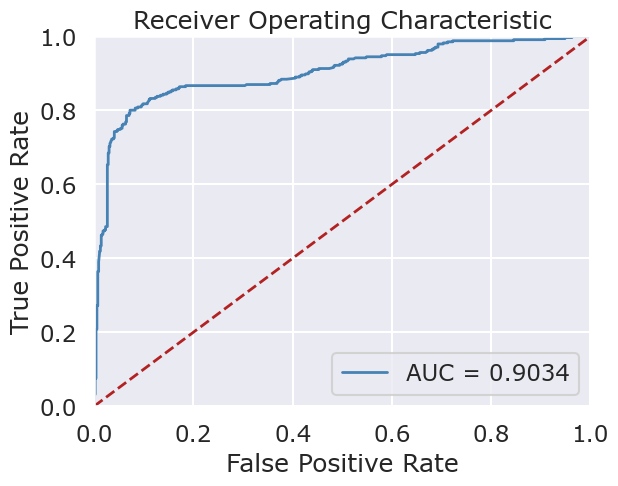

In [99]:
# plot the ROC-AUC curve for the 'best classifier'
plot_roc_auc_curve(pipe_svcg, X_train, y_train)

In [101]:
from sklearn.model_selection import learning_curve, validation_curve

def get_lc_scores(clf, X_train, y_train, train_size_props=None, cv_folds=4, verbose=False):
    # calculate scores for learning curves
    #train_size_props = [0.10, 0.25, 0.33, 0.45, 0.50, 0.66, 0.75, 0.85, 0.90, 1.0]
    if train_size_props is None:
        train_size_props = np.linspace(0.1,1.0,10)
    train_sizes, train_scores, test_scores = \
      learning_curve(clf, X_train, y_train,train_sizes=train_size_props,cv=cv_folds)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    if verbose:
        print('Train sizes:') 
        print(train_sizes)
        print('\nTraining mean scores')
        print(train_mean)
        print('\nValidation mean scores')
        print(test_mean)
    return train_sizes, train_mean, train_std, test_mean, test_std

def plot_learning_curve(clf, X_train, y_train, desired_accuracy_score,train_size_props=None, cv_folds=4, verbose=False):
    train_sizes, train_mean, train_std, test_mean, test_std = \
        get_lc_scores(clf, X_train, y_train, train_size_props, cv_folds, verbose)
    plt.subplots(figsize=(6,4))
    plt.plot(train_sizes, train_mean, lw=2, color='steelblue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='steelblue')
    plt.plot(train_sizes, test_mean, lw=2, color='forestgreen', marker='o', markersize=5, label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='forestgreen')
    plt.axhline(y=desired_accuracy_score, lw=2, color='firebrick', linestyle='--', label='Desired Accuracy')
    plt.xlabel('No. of training samples')
    plt.ylabel('Accuracy Scores')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()
    plt.close()

In [102]:
# picking out the desired accuracy from scores_df calculated above
scores_df.sort_values(by=['accuracy_scores'], ascending=False, inplace=True)
desired_accuracy_score = scores_df.iloc[0]['accuracy_scores']
desired_accuracy_score

0.9606986899563319

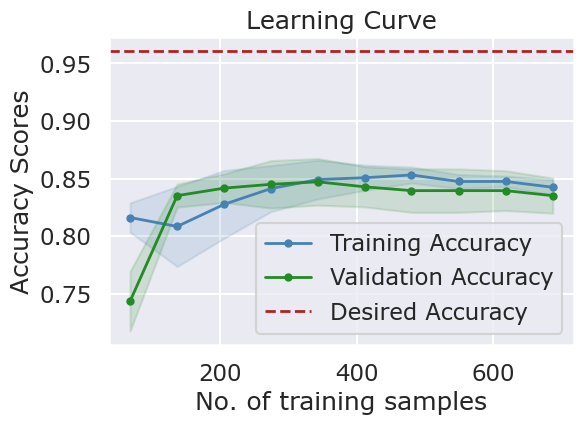

In [119]:
plot_learning_curve(clf_nb, X_train, y_train, desired_accuracy_score)

In [111]:
from sklearn.decomposition import PCA

clf_list2 = []

clf_list2.append((clf_gbm, 'Gradient Boosting Classifier [PCA=All]'))

clf_gbm5 = Pipeline([('pca', PCA(n_components=5)),
                     ('clf', GradientBoostingClassifier(loss='log_loss',learning_rate=0.1,
                                                        n_estimators=100,max_depth=5,random_state=seed))])
clf_list2.append((clf_gbm5, 'Gradient Boosting Classifier [PCA=5]'))

clf_gbm4 = Pipeline([('pca', PCA(n_components=4)),
                     ('clf', GradientBoostingClassifier(loss='log_loss',learning_rate=0.1,
                                                        n_estimators=100,max_depth=5,random_state=seed))])
clf_list2.append((clf_gbm4, 'Gradient Boosting Classifier [PCA=4]'))

clf_gbm3 = Pipeline([('pca', PCA(n_components=3)),
                     ('clf', GradientBoostingClassifier(loss='log_loss',learning_rate=0.1,
                                                        n_estimators=100,max_depth=5,random_state=seed))])
clf_list2.append((clf_gbm3, 'Gradient Boosting Classifier [PCA=3]'))

In [112]:
scores_df2 = test_classifiers(clf_list2, X_train, y_train, verbose=2)
print('Done!')

Testing classifier Gradient Boosting Classifier [PCA=All]...
   - cross-val scores : Mean - 0.892 Std - 0.005 Min - 0.887 Max - 0.901
   - accuracy score   : 0.961
   - auc score        : 0.992
Testing classifier Gradient Boosting Classifier [PCA=5]...
   - cross-val scores : Mean - 0.847 Std - 0.019 Min - 0.818 Max - 0.864
   - accuracy score   : 0.965
   - auc score        : 0.993
Testing classifier Gradient Boosting Classifier [PCA=4]...
   - cross-val scores : Mean - 0.762 Std - 0.021 Min - 0.746 Max - 0.797
   - accuracy score   : 0.962
   - auc score        : 0.988
Testing classifier Gradient Boosting Classifier [PCA=3]...
   - cross-val scores : Mean - 0.703 Std - 0.018 Min - 0.687 Max - 0.732
   - accuracy score   : 0.942
   - auc score        : 0.986
Done!


In [113]:
scores_df2.sort_values(by=['accuracy_scores'], ascending=False, inplace=True)
print('\nClassifiers sorted by Accuracy Scores (descending):')
print(scores_df2)

scores_df2.sort_values(by=['cv_scores_mean'], ascending=False, inplace=True)
print('\nClassifiers sorted by mean cv_scores (descending):')
print(scores_df2)

scores_df2.sort_values(by=['auc_scores'], ascending=False, inplace=True)
print('\nClassifiers sorted by AUC scores (descending):')
print(scores_df2)



Classifiers sorted by Accuracy Scores (descending):
                                        cv_scores_mean  accuracy_scores  auc_scores
Gradient Boosting Classifier [PCA=5]            0.8468           0.9651      0.9934
Gradient Boosting Classifier [PCA=4]            0.7618           0.9618      0.9879
Gradient Boosting Classifier [PCA=All]          0.8924           0.9607      0.9922
Gradient Boosting Classifier [PCA=3]            0.7027           0.9421      0.9857

Classifiers sorted by mean cv_scores (descending):
                                        cv_scores_mean  accuracy_scores  auc_scores
Gradient Boosting Classifier [PCA=All]          0.8924           0.9607      0.9922
Gradient Boosting Classifier [PCA=5]            0.8468           0.9651      0.9934
Gradient Boosting Classifier [PCA=4]            0.7618           0.9618      0.9879
Gradient Boosting Classifier [PCA=3]            0.7027           0.9421      0.9857

Classifiers sorted by AUC scores (descending):
       

In [80]:
# now let's predict the results on the test dataset
y_pred = clf_rf.predict(X_test)  # GBC with all features
test_df2['Survived-A'] = y_pred

y_pred5 = clf_gbm5.predict(X_test)  # GBC with PCA=5
test_df2['Survived'] = y_pred5

test_df2.head()

,pclass,age,fare,fob,title_2,title_3,title_4,embarked_2,embarked_3,Survived-A,Survived
0,3,15.0000,8.0292,0,0,0,1,0,0,1,1
1,2,32.0000,13.0000,0,0,1,0,0,1,1,1
2,3,21.9495,7.7500,0,0,0,1,0,0,1,1
3,3,33.4574,7.2500,0,0,0,0,0,1,0,0
4,1,45.0000,164.8667,1,0,1,0,0,1,1,0


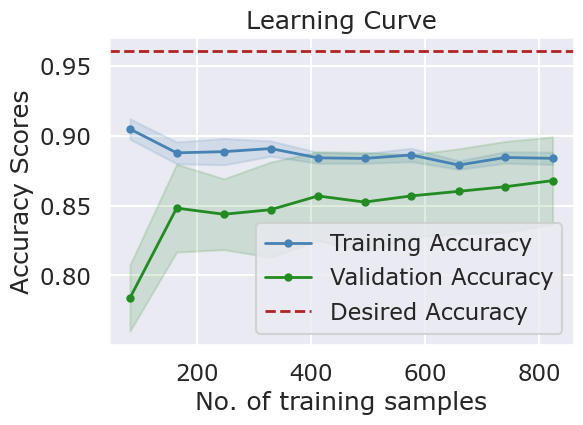

In [81]:
plot_learning_curve(clf_rf, X_train, y_train, desired_accuracy_score)

In [78]:
k = pd.read_csv('data/test.csv')
test_passengerid = k.passengerid.values

In [82]:
submission = pd.DataFrame({'passengerid': test_passengerid, 'Survived': y_pred})
submission.to_csv('data/submission_rf.csv', index=False)